In [1]:
import pandas as pd
from pathlib import Path

# === 1) home path(where the data is stored)
BASE_PATH = Path.home() / "Documents" / "monarq_data"

# === 2) target coins
SPOT_SYMBOLS = ["BTCUSDT", "ETHUSDT"]

ALL_SYMBOLS = SPOT_SYMBOLS

ALL_SYMBOLS

['BTCUSDT', 'ETHUSDT']

In [2]:
# === 3) data types list
CORE_DATA_TYPES = ["trade_1min", "level1_1min", "book_1min", "openinterest_1min"]

# optional: if we can get liquidation data later it's ok to add it.
INCLUDE_LIQUIDATION = False   # no data

if INCLUDE_LIQUIDATION:
    DATA_TYPES = CORE_DATA_TYPES + ["liquidation_1min"]
else:
    DATA_TYPES = CORE_DATA_TYPES

DATA_TYPES

['trade_1min', 'level1_1min', 'book_1min', 'openinterest_1min']

In [3]:
TYPE_PREFIX = {
    "trade_1min": "tr",   # trade
    "level1_1min": "l1",  # L1 order book
    "book_1min":   "l2",  # L2 order book
    "openinterest_1min": "oi",  # open interest
    "liquidation_1min": "liq",  # no data but with integral structure
}

In [4]:
def load_one_type_symbol(base_path: Path, data_type: str, symbol: str, prefix: str):
    """
    Read all 1-minute files for a given symbol (e.g., 'BTCUSDT') under a given data_type (e.g., 'trade_1min').

    Perform basic cleaning and prefix the columns.

    - If the directory does not exist/there are no files, return None and print a [WARN].

    - ts_end: Treats as millisecond-level timestamps → converts to UTC datetime and sets it as the index.
    """
    folder = base_path / data_type / symbol
    if not folder.exists():
        print(f"[WARN] Folder not found: {folder}")
        return None

    files = sorted(folder.glob("*.csv.gz"))
    if not files:
        print(f"[WARN] No files in {folder}")
        return None

    dfs = []
    for f in files:
        try:
            df = pd.read_csv(f)
            dfs.append(df)
        except Exception as e:
            print(f"[WARN] Failed to read {f}: {e}")

    if not dfs:
        print(f"[WARN] No valid dataframes for {data_type} / {symbol}")
        return None

    df = pd.concat(dfs, ignore_index=True)

    # Timestamp processing: Server data is ts_end in ms
    if "ts_end" not in df.columns:
        print(f"[WARN] ts_end missing in {data_type} / {symbol}, columns={df.columns.tolist()}")
        return None

    df["ts_end"] = pd.to_datetime(df["ts_end"], unit="ms", utc=True)
    df = df.sort_values("ts_end").set_index("ts_end")

    # Remove duplicate timestamps (keep the last one).
    df = df[~df.index.duplicated(keep="last")]

    # Add a prefix to all columns to avoid column name conflicts during subsequent joins.
    col_map = {col: f"{prefix}__{col}" for col in df.columns}
    df = df.rename(columns=col_map)

    return df


In [5]:
def build_combined_symbol_df(base_path: Path,
                             symbol: str,
                             data_types=DATA_TYPES,
                             type_prefix_map=TYPE_PREFIX):
    """
    For a given symbol (e.g., 'BTCUSDT'), load all specified data types,

    and perform an outer join based on the time index to obtain a complete 1-minute data table.

    - Note: openinterest_1min currently only has data for 2024;

    For the 2023 time period, the corresponding oi__* columns will naturally all be NaN → this is normal and acceptable.

    - liquidation_1min is not loaded by default because this directory is empty on the server.
    """
    dfs = []
    for dt in data_types:
        prefix = type_prefix_map.get(dt, dt)
        df = load_one_type_symbol(base_path, dt, symbol, prefix)
        if df is not None and not df.empty:
            dfs.append(df)
        else:
            print(f"[INFO] Skip empty {dt} for {symbol}")

    if not dfs:
        print(f"[ERROR] No data loaded at all for {symbol}")
        return None

    combined = dfs[0]
    for df in dfs[1:]:
        # Outer join indexed by time, not mandatory to include all elements
        combined = combined.join(df, how="outer")

    # Sort by time again, just to be on the safe side.
    combined = combined.sort_index()

    return combined

In [6]:
btc_spot = build_combined_symbol_df(BASE_PATH, "BTCUSDT")
btc_spot.shape, btc_spot.head()

((1052641, 113),
                            tr__bin_id  tr__carryover  tr__ramp_up  \
 ts_end                                                              
 2023-01-01 00:00:00+00:00         NaN            NaN          NaN   
 2023-01-01 00:01:00+00:00         0.0            0.0          0.0   
 2023-01-01 00:02:00+00:00         1.0            0.0          1.0   
 2023-01-01 00:03:00+00:00         2.0            0.0          2.0   
 2023-01-01 00:04:00+00:00         3.0            0.0          3.0   
 
                            tr__trade_count  tr__buy_trade_count  \
 ts_end                                                            
 2023-01-01 00:00:00+00:00              NaN                  NaN   
 2023-01-01 00:01:00+00:00            946.0                213.0   
 2023-01-01 00:02:00+00:00            570.0                147.0   
 2023-01-01 00:03:00+00:00            456.0                 46.0   
 2023-01-01 00:04:00+00:00            980.0                111.0   
 
             

In [7]:
combined_data = {}

for sym in ALL_SYMBOLS:
    print(f"\n=== Building combined df for {sym} ===")
    df = build_combined_symbol_df(BASE_PATH, sym)
    if df is not None:
        combined_data[sym] = df
        print(f"{sym}: shape = {df.shape}")
    else:
        print(f"[WARN] No combined df for {sym}")


=== Building combined df for BTCUSDT ===
BTCUSDT: shape = (1052641, 113)

=== Building combined df for ETHUSDT ===
ETHUSDT: shape = (1052641, 113)


In [8]:
symbols_keep = ["BTCUSDT", "ETHUSDT"]

combined_data_clean = {sym: combined_data[sym] for sym in symbols_keep}

In [9]:
# import the funding rate data
# Change to your own path
import glob
base_path = "/Users/zhangyichi/Documents/binance_rates/"

# Example: Read all data from ETHUSDT
files = glob.glob(base_path + "ETHUSDT*.csv.gz")

print("Number of files found:", len(files))

df_list = []
for f in sorted(files):
    tmp = pd.read_csv(f)
    tmp['source_file'] = f   # optional: Keep source files
    df_list.append(tmp)

bnb_rates = pd.concat(df_list, ignore_index=True)

bnb_rates.head()

Number of files found: 1464


,ts,rate,interval,next_ts,next_rate,dt,source_file
0,1.672531e+12,0.0001,NaN,1.672560e+12,NaN,2023-01-01 00:00:00,/Users/zhangyichi/Documents/binance_rates/ETHU...
1,1.672535e+12,0.0001,NaN,1.672560e+12,NaN,2023-01-01 01:00:00,/Users/zhangyichi/Documents/binance_rates/ETHU...
2,1.672538e+12,0.0001,NaN,1.672560e+12,NaN,2023-01-01 02:00:00,/Users/zhangyichi/Documents/binance_rates/ETHU...
3,1.672542e+12,0.0001,NaN,1.672560e+12,NaN,2023-01-01 03:00:00,/Users/zhangyichi/Documents/binance_rates/ETHU...
4,1.672546e+12,0.0001,NaN,1.672560e+12,NaN,2023-01-01 04:00:00,/Users/zhangyichi/Documents/binance_rates/ETHU...


In [10]:
# Replace this with your own complete path
import os
base_path = "/Users/zhangyichi/Documents/binance_rates"

symbols = ["BTCUSDT", "ETHUSDT"]


# ========= 2. Read the funding rate of a single symbol ==========

def load_symbol_rates(symbol: str, base_path: str) -> pd.DataFrame:
    """
    Read all rates_light.csv.gz files for a given symbol,

    and return a normalized DataFrame: ['ts', 'dt', 'rate'], sorted by time.
    """
    pattern = os.path.join(base_path, f"{symbol}*.rates_light.csv.gz")
    files = sorted(glob.glob(pattern))
    
    if not files:
        raise FileNotFoundError(f"No files found for {symbol} with pattern: {pattern}")
    
    df_list = []
    for f in files:
        tmp = pd.read_csv(f)
        
        # Standardized column names: ts (timestamp in milliseconds), rate (funding rate)
        cols = {c.lower(): c for c in tmp.columns}  # Lowercase mapping to the original column name
        
        # Try to find the timestamp column
        if "ts" in cols:
            ts_col = cols["ts"]
        elif "timestamp" in cols:
            ts_col = cols["timestamp"]
        elif "fundingtime" in cols:
            ts_col = cols["fundingtime"]
        else:
            raise KeyError(f"Cannot find a timestamp column in {f}, columns: {tmp.columns}")
        
        # Try to find the rate column
        if "rate" in cols:
            rate_col = cols["rate"]
        elif "fundingrate" in cols:
            rate_col = cols["fundingrate"]
        else:
            raise KeyError(f"Cannot find a rate column in {f}, columns: {tmp.columns}")
        
        # Keep only the columns you need
        tmp = tmp[[ts_col, rate_col]].copy()
        tmp.columns = ["ts", "rate"]
        
        # The time signature (ts) might be read in as a float, converted to an integer, and then converted to time.
        tmp["ts"] = tmp["ts"].astype("int64")
        tmp["dt"] = pd.to_datetime(tmp["ts"], unit="ms", utc=True)
        
        # Adding a symbol field makes merging easier later.
        tmp["symbol"] = symbol
        
        df_list.append(tmp)
    
    df = pd.concat(df_list, ignore_index=True)
    df = df.sort_values("dt").drop_duplicates(subset=["dt"])  # 按时间排序 & 去重
    return df[["ts", "dt", "symbol", "rate"]]


# ========= 3. Read 5 coins in batch and get a dictionary + panel table.==========

def load_all_funding_rates(symbols, base_path):
    """
    return :
      rates_dict: {symbol -> df(ts, dt, symbol, rate)}
      panel_df: large df，index=dt, columns=symbol, values=rate
    """
    rates_dict = {}
    all_list = []
    
    for sym in symbols:
        df = load_symbol_rates(sym, base_path)
        rates_dict[sym] = df
        all_list.append(df)
    
    long_df = pd.concat(all_list, ignore_index=True)
    
    # Wide table: Each row contains a timestamp, and each column contains a symbol representing the funding rate.
    panel_df = long_df.pivot(index="dt", columns="symbol", values="rate").sort_index()
    
    return rates_dict, panel_df


# ========= 4. Actual execution loading==========
rates_dict, panel_rates = load_all_funding_rates(symbols, base_path)

# 
for s in symbols:
    print(f"\n=== {s} ===")
    print(rates_dict[s].head())

print("\nPanel wide table (first 5 rows):")
print(panel_rates.head())


=== BTCUSDT ===
                  ts                        dt   symbol    rate
0      1672531200000 2023-01-01 00:00:00+00:00  BTCUSDT  0.0001
15274  1672534800000 2023-01-01 01:00:00+00:00  BTCUSDT  0.0000
2      1672538400000 2023-01-01 02:00:00+00:00  BTCUSDT  0.0001
3      1672542000000 2023-01-01 03:00:00+00:00  BTCUSDT  0.0001
15277  1672545600000 2023-01-01 04:00:00+00:00  BTCUSDT  0.0000

=== ETHUSDT ===
                  ts                        dt   symbol    rate
0      1672531200000 2023-01-01 00:00:00+00:00  ETHUSDT  0.0001
15443  1672534800000 2023-01-01 01:00:00+00:00  ETHUSDT  0.0000
2      1672538400000 2023-01-01 02:00:00+00:00  ETHUSDT  0.0001
3      1672542000000 2023-01-01 03:00:00+00:00  ETHUSDT  0.0001
15446  1672545600000 2023-01-01 04:00:00+00:00  ETHUSDT  0.0000

Panel wide table (first 5 rows):
symbol                     BTCUSDT  ETHUSDT
dt                                         
2023-01-01 00:00:00+00:00   0.0001   0.0001
2023-01-01 01:00:00+00:00   0.00

In [11]:
def rebuild_all_pdf_features(
    combined_data_clean: dict,
    base_symbol: str = "BTCUSDT"
) -> dict:
    """
    Reconstructs all necessary features (excluding sentiment) from the PDF using `combined_data_clean`.

    Assumptions:

    - The index of each data frame is `ts_end` (datetime, UTC).

    - The original microstructure columns `tr__*`, `l1__*`, `l2__*`, `oi__*`, `OFI_raw`, `rv_fwd_*`, etc., already exist.

    Parameters:

    `combined_data_clean`: {symbol -> DataFrame}

    `funding_long`: Optional; must have at least `['dt', 'symbol', 'funding_rate']`, where `dt` is the minute-based UTC value.

    `base_symbol`: The base currency for the cross-asset, defaults to 'BTCUSDT'.

    Returns:

    `combined_data_full`: {symbol -> DataFrame}, containing all features.
    """

    eps = 1e-8  # 
    combined_out = {}

    # ---------- 0. Prepare the datasheet for base_symbol for cross-asset. ----------
    if base_symbol not in combined_data_clean:
        raise KeyError(f"base_symbol '{base_symbol}' not in combined_data_clean")

    # First, process the basic fields of base_df (ret_1m, rv_30m, etc.), then use them for cross-asset processing.
    def _prepare_base_df(df_base: pd.DataFrame) -> pd.DataFrame:
        dfb = df_base.copy()

    # index -> dt, symbol
        if "dt" not in dfb.columns:
            dfb["dt"] = pd.to_datetime(dfb.index)
        if "symbol" not in dfb.columns:
            pass  # 

    # ===== Add OFI_raw logic here. =====
        if "OFI_raw" not in dfb.columns:
            if {"tr__buy_volume", "tr__sell_volume"}.issubset(dfb.columns):
                dfb["OFI_raw"] = dfb["tr__buy_volume"] - dfb["tr__sell_volume"]
            else:
                print("⚠ base df don't have buy/sell volume，can't get OFI_raw")
                dfb["OFI_raw"] = np.nan

    # ret_1m
        if "ret_1m" not in dfb.columns:
            if "tr__close_price" in dfb.columns:
                dfb["ret_1m"] = dfb["tr__close_price"].pct_change()
            else:
                print("⚠ base df don't have tr__close_price，can't get ret_1m")
                dfb["ret_1m"] = np.nan

    # rv_30m
        if "rv_30m" not in dfb.columns:
            if "ret_1m" in dfb.columns:
                dfb["rv_30m"] = (
                    dfb["ret_1m"].pow(2)
                    .rolling(window=30, min_periods=10)
                    .sum()
                )
            else:
                print("⚠ base df don't have ret_1m，can't get rv_30m")
                dfb["rv_30m"] = np.nan

        return dfb


    base_df_raw = combined_data_clean[base_symbol]
    base_df = _prepare_base_df(base_df_raw)

    # Note: The symbol name is not yet known in base_df, but since the cross-asset is only aligned by time, base_df["symbol"] will not be used later.

    # ---------- 2. Build all features for each symbol ----------
    for sym, df0 in combined_data_clean.items():
        print(f"\n=== Rebuilding features for {sym} ===")

        df = df0.copy()

        # 2.1 Basics: index -> dt, symbol
        if "dt" not in df.columns:
            df["dt"] = pd.to_datetime(df.index)
        df["dt"] = pd.to_datetime(df["dt"], utc=True)

        if "symbol" not in df.columns:
            df["symbol"] = sym
        else:
            df["symbol"] = df["symbol"].fillna(sym)

        # 2.2 ret_1m & rv_30m
        if "ret_1m" not in df.columns:
            if "tr__close_price" in df.columns:
                df["ret_1m"] = df["tr__close_price"].pct_change()
            else:
                print("⚠ no tr__close_price，can't get ret_1m")
                df["ret_1m"] = np.nan

        if "rv_30m" not in df.columns:
            if "ret_1m" in df.columns:
                df["rv_30m"] = (
                    df["ret_1m"].pow(2)
                    .rolling(window=30, min_periods=10)
                    .sum()
                )
            else:
                print("⚠ no ret_1m，can't get rv_30m")
                df["rv_30m"] = np.nan

        # ---------- 3. Basic / Interaction / Derived PDF Features ----------

                # 2.x If OFI_raw is not available, construct one using the volume difference.
        if "OFI_raw" not in df.columns:
            if {"tr__buy_volume", "tr__sell_volume"}.issubset(df.columns):
                df["OFI_raw"] = df["tr__buy_volume"] - df["tr__sell_volume"]
            else:
                print(f"⚠ {sym} no buy/sell volume，can't get OFI_raw")
                df["OFI_raw"] = np.nan
        
        
        # 3.1 L1_Imbalance
        if {"l1__close_bid_size", "l1__close_ask_size"}.issubset(df.columns):
            bid_sz = df["l1__close_bid_size"]
            ask_sz = df["l1__close_ask_size"]
            df["L1_Imbalance"] = (bid_sz - ask_sz) / (bid_sz + ask_sz + eps)
        else:
            df["L1_Imbalance"] = np.nan

        # 3.2 VWAP_deviation
        if {"tr__vwap", "tr__close_price"}.issubset(df.columns):
            df["VWAP_deviation"] = (df["tr__vwap"] - df["tr__close_price"]) / (df["tr__close_price"] + eps)
        else:
            df["VWAP_deviation"] = np.nan

        # 3.3 VPIN_proxy
        if {"tr__buy_volume", "tr__sell_volume"}.issubset(df.columns):
            buy_v = df["tr__buy_volume"]
            sell_v = df["tr__sell_volume"]
            df["VPIN_proxy"] = (buy_v - sell_v).abs() / (buy_v + sell_v + eps)
        else:
            df["VPIN_proxy"] = np.nan

        # 3.4 Trade_Intensity
        if "tr__trade_count" in df.columns:
            df["Trade_Intensity"] = df["tr__trade_count"].astype(float)
        else:
            df["Trade_Intensity"] = np.nan

        # 3.5 Liquidity_Weighted_OFI
        if {"OFI_raw", "l1__mean_bid_size", "l1__mean_ask_size"}.issubset(df.columns):
            depth = df["l1__mean_bid_size"] + df["l1__mean_ask_size"]
            df["Liquidity_Weighted_OFI"] = df["OFI_raw"] * depth
        else:
            df["Liquidity_Weighted_OFI"] = np.nan

        # 3.6 Mean_Spread
        if "l1__mean_spread" in df.columns:
            df["Mean_Spread"] = df["l1__mean_spread"]
        else:
            df["Mean_Spread"] = np.nan

        # 3.7 OFI_std_30m
        if "OFI_raw" in df.columns:
            df["OFI_std_30m"] = (
                df["OFI_raw"]
                .rolling(window=30, min_periods=10)
                .std()
            )
        else:
            df["OFI_std_30m"] = np.nan

        # 3.8 Spread_ma_15m
        if "l1__mean_spread" in df.columns:
            df["Spread_ma_15m"] = (
                df["l1__mean_spread"]
                .rolling(window=15, min_periods=5)
                .mean()
            )
        else:
            df["Spread_ma_15m"] = np.nan

        # 3.9 OFI_roc_10m
        if "OFI_raw" in df.columns:
            ofi = df["OFI_raw"]
            ofi_lag10 = ofi.shift(10)
            df["OFI_roc_10m"] = (ofi - ofi_lag10) / (ofi_lag10.abs() + eps)
        else:
            df["OFI_roc_10m"] = np.nan

        # 3.10 Price_Impact_per_Volume
        if {"tr__close_price", "tr__volume"}.issubset(df.columns):
            ret_15m = df["tr__close_price"].pct_change(15)
            vol_15m = (
                df["tr__volume"]
                .rolling(window=15, min_periods=5)
                .sum()
            )
            df["Price_Impact_per_Volume"] = ret_15m.abs() / (vol_15m + eps)
        else:
            df["Price_Impact_per_Volume"] = np.nan

        # ---------- 4. L2 related large order depth & imbalance ----------

        needed_l2 = {
            "l2__bid_10000K_fill_dsize", "l2__ask_10000K_fill_dsize",
            "l2__bid_100000K_fill_dsize", "l2__ask_100000K_fill_dsize",
        }
        if needed_l2.issubset(df.columns):
            df["depth_ratio_10M"] = (
                df["l2__bid_10000K_fill_dsize"] /
                (df["l2__ask_10000K_fill_dsize"] + eps)
            )
            df["depth_ratio_100M"] = (
                df["l2__bid_100000K_fill_dsize"] /
                (df["l2__ask_100000K_fill_dsize"] + eps)
            )
            df["l2_imbalance_10M"] = (
                df["l2__bid_10000K_fill_dsize"] - df["l2__ask_10000K_fill_dsize"]
            ) / (
                df["l2__bid_10000K_fill_dsize"] + df["l2__ask_10000K_fill_dsize"] + eps
            )
        else:
            df["depth_ratio_10M"] = np.nan
            df["depth_ratio_100M"] = np.nan
            df["l2_imbalance_10M"] = np.nan

        # ---------- 6. Cross-Asset Features (Based on BTC)----------

        # Align base_df to the current symbol's time index
        base_aligned = base_df.reindex(df.index)

        # 6.1 BTC_lag15_rv_30m
        if "rv_30m" in base_aligned.columns:
            df["BTC_lag15_rv_30m"] = base_aligned["rv_30m"].shift(15)
        else:
            df["BTC_lag15_rv_30m"] = np.nan

        # 6.2 BTC_lag15_OFI_raw
        if "OFI_raw" in base_aligned.columns:
            df["BTC_lag15_OFI_raw"] = base_aligned["OFI_raw"].shift(15)
        else:
            df["BTC_lag15_OFI_raw"] = np.nan

        # 6.3 BTC_lag15_ret_1m
        if "ret_1m" in base_aligned.columns:
            df["BTC_lag15_ret_1m"] = base_aligned["ret_1m"].shift(15)
        else:
            df["BTC_lag15_ret_1m"] = np.nan

        # 6.4 BTC_corr_60m : Corr(ret^sym, ret^BTC) over 60 min using rolling corr
        if "ret_1m" in df.columns and "ret_1m" in base_aligned.columns:
            df["BTC_corr_60m"] = (
                df["ret_1m"]
                .rolling(60, min_periods=10)
                .corr(base_aligned["ret_1m"])
            )
        else:
            df["BTC_corr_60m"] = np.nan

        # ---------- 7. return dict ----------
        combined_out[sym] = df

    return combined_out

In [12]:
combined_data_full = rebuild_all_pdf_features(
    combined_data_clean,
    base_symbol="BTCUSDT"
)



=== Rebuilding features for BTCUSDT ===

=== Rebuilding features for ETHUSDT ===


In [13]:
pd.set_option('display.max_rows', None)      # 
pd.set_option('display.max_columns', None)   # 
pd.set_option('display.width', None)         # 
pd.set_option('display.max_colwidth', None)  # 

df = combined_data_full["ETHUSDT"]   # the one u r trying to examine

nan_summary = pd.DataFrame({
    "nan_count": df.isna().sum(),
    "nan_ratio": df.isna().mean()
})

print(nan_summary.sort_values("nan_ratio", ascending=False))

                            nan_count     nan_ratio
oi__ts                         525601  4.993165e-01
oi__value                      525601  4.993165e-01
l1__tick_volatility              3622  3.440869e-03
l1__max_bid                      3618  3.437069e-03
l1__close_ask_size               3618  3.437069e-03
l1__first_mid                    3618  3.437069e-03
l1__close_mid                    3618  3.437069e-03
l1__min_mid                      3618  3.437069e-03
l1__max_mid                      3618  3.437069e-03
l1__close_bid                    3618  3.437069e-03
l1__min_ask                      3618  3.437069e-03
L1_Imbalance                     3618  3.437069e-03
l1__close_ask                    3618  3.437069e-03
l1__close_bid_size               3618  3.437069e-03
Mean_Spread                      3618  3.437069e-03
Liquidity_Weighted_OFI           3618  3.437069e-03
l1__median_spread                3618  3.437069e-03
l1__mean_spread                  3618  3.437069e-03
l1__min_spre

In [14]:
# First, ensure that ret_1m has been built in the previous step
import numpy as np

def make_forward_rv(df, horizon):
    """
    `horizon` = Scroll forward window size, in minutes

    Returns the realized volatility (RV) for the next `horizon` minutes

    Formula = sqrt(sum of squared one-minute returns for the next `horizon` minutes)
    """
    rv = (
        df["ret_1m"]
        .rolling(horizon)
        .apply(lambda x: np.sqrt((x**2).sum()), raw=True)
        .shift(-horizon)
    )
    return rv

In [15]:
# Generate labels for all horizons
horizons = {
    "rv_fwd_1m": 1,
    "rv_fwd_5m": 5,
    "rv_fwd_15m": 15,   
    "rv_fwd_30m": 30,
    "rv_fwd_60m": 60,
}

for label, h in horizons.items():
    df[label] = make_forward_rv(df, h)

df["rv_fwd_1h"] = df["rv_fwd_60m"]   


In [16]:
labels = ["rv_fwd_1m", "rv_fwd_5m", "rv_fwd_15m", "rv_fwd_30m", "rv_fwd_60m"]

df[labels].isna().mean()

rv_fwd_1m     0.000002
rv_fwd_5m     0.000006
rv_fwd_15m    0.000015
rv_fwd_30m    0.000029
rv_fwd_60m    0.000058
dtype: float64

In [17]:
# The label name to be generated and its horizon
horizon_map = {
    "rv_fwd_1m": 1,
    "rv_fwd_5m": 5,
    "rv_fwd_15m": 15,
    "rv_fwd_30m": 30,
    "rv_fwd_60m": 60,
}

for sym, df in combined_data_full.items():
    df = df.copy()
    
    # Ensure that ret_1m exists.
    if "ret_1m" not in df.columns:
        df["ret_1m"] = df["tr__close_price"].pct_change(fill_method=None)
    
    # generate each horizon's RV label
    for label, h in horizon_map.items():
        df[label] = make_forward_rv(df, h)

    
    combined_data_full[sym] = df
    print(f"{sym}: labels added: {list(horizon_map.keys())}")

BTCUSDT: labels added: ['rv_fwd_1m', 'rv_fwd_5m', 'rv_fwd_15m', 'rv_fwd_30m', 'rv_fwd_60m']
ETHUSDT: labels added: ['rv_fwd_1m', 'rv_fwd_5m', 'rv_fwd_15m', 'rv_fwd_30m', 'rv_fwd_60m']


In [18]:
for sym in combined_data_full:
    df = combined_data_full[sym]
    print(f"\n=== {sym} ===")
    print(df[labels].isna().mean())



=== BTCUSDT ===
rv_fwd_1m     0.000002
rv_fwd_5m     0.000006
rv_fwd_15m    0.000015
rv_fwd_30m    0.000029
rv_fwd_60m    0.000058
dtype: float64

=== ETHUSDT ===
rv_fwd_1m     0.000002
rv_fwd_5m     0.000006
rv_fwd_15m    0.000015
rv_fwd_30m    0.000029
rv_fwd_60m    0.000058
dtype: float64


In [19]:
import pandas as pd

# 1. Convert the funding rate of a single symbol to a 1-minute frequency.
def build_1min_funding(rates_df: pd.DataFrame) -> pd.DataFrame:
    """
    Input: df(ts, dt, symbol, rate) from rates_dict[sym]

    Output: Index dt (1-minute frequency), column ['funding_rate']
    """
    tmp = rates_df.copy()
    tmp = tmp.set_index("dt").sort_index()
    
    # The original interval was 8 hours per jump (or similar), but here it's been reduced to 1 minute and forward-filled.
    ser = tmp["rate"].resample("1min").ffill()
    
    out = ser.to_frame(name="funding_rate")
    return out


# 2. Merge the funding data into combined_data_full to generate a new dictionary.
final_data = {}

for sym, df_raw in combined_data_full.items():
    print(f"\n=== merge funding for {sym} ===")
    
    df = df_raw.copy()
    
    # (a) Ensure that `ts_end` exists and convert it to `dt`.
    # If ts_end is an index, then reset it.
    if "ts_end" in df.columns:
        dt = pd.to_datetime(df["ts_end"], utc=True)
    else:
        # ts_end at index
        # You can first check if the name of df.index is 'ts_end'.
        # print(df.index.name)
        df = df.reset_index().rename(columns={"index": "ts_end"})
        dt = pd.to_datetime(df["ts_end"], utc=True)
    
    df["dt"] = dt
    
    # (b) Adding a symbol column will facilitate future panel operations.
    df["symbol"] = sym
    
    # (c) Prepare the 1-min funding sequence for this symbol.
    fund_1min = build_1min_funding(rates_dict[sym])
    # fund_1min.index is dt，where contains funding_rate
    
    # (d) Merge funding by time
    df_merged = df.merge(
        fund_1min,
        left_on="dt",
        right_index=True,
        how="left"
    )
    
    final_data[sym] = df_merged
    print(sym, "merged shape:", df_merged.shape)



=== merge funding for BTCUSDT ===
BTCUSDT merged shape: (1052641, 142)

=== merge funding for ETHUSDT ===
ETHUSDT merged shape: (1052641, 143)


In [20]:
df_btc = final_data["BTCUSDT"]
df_btc[["ts_end", "dt", "symbol", "funding_rate"]].head()


,ts_end,dt,symbol,funding_rate
0,2023-01-01 00:00:00+00:00,2023-01-01 00:00:00+00:00,BTCUSDT,0.0001
1,2023-01-01 00:01:00+00:00,2023-01-01 00:01:00+00:00,BTCUSDT,0.0001
2,2023-01-01 00:02:00+00:00,2023-01-01 00:02:00+00:00,BTCUSDT,0.0001
3,2023-01-01 00:03:00+00:00,2023-01-01 00:03:00+00:00,BTCUSDT,0.0001
4,2023-01-01 00:04:00+00:00,2023-01-01 00:04:00+00:00,BTCUSDT,0.0001


In [21]:
from typing import Dict

def enhance_features(data_dict: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    """
    Building upon existing microstructure features, add a few high-value, simple features:

    - `signed_ret_1m`: Directional 1-minute return

    - `abs_ret_1m`: Absolute return, used for short-term volatility prediction

    - `log_volume`: Log(volume), mitigating the impact of extreme values

    Assumptions:

    - Existing columns `tr__close_price`, `tr__volume` (from transaction data)

    Parameters:
    
    `data_dict`: {symbol -> DataFrame}

    Returns:

    `out_dict`: {symbol -> DataFrame} (a ​​shallow copy of the dictionary, without modifying the original object references)
    """
    out_dict = {}

    for sym, df in data_dict.items():
        df_enh = df.copy()

        # 1. signed_ret_1m: If ret_1m already exists, reuse it directly; otherwise, calculate based on tr__close_price.
        if "signed_ret_1m" not in df_enh.columns:
            if "ret_1m" in df_enh.columns:
                df_enh["signed_ret_1m"] = df_enh["ret_1m"]
            elif "tr__close_price" in df_enh.columns:
                df_enh["signed_ret_1m"] = df_enh["tr__close_price"].pct_change()
            else:
                df_enh["signed_ret_1m"] = np.nan

        # 2. abs_ret_1m: Absolute return (most useful for volatility)
        if "abs_ret_1m" not in df_enh.columns:
            if "signed_ret_1m" in df_enh.columns:
                df_enh["abs_ret_1m"] = df_enh["signed_ret_1m"].abs()
            else:
                df_enh["abs_ret_1m"] = np.nan

        # 3. log_volume: log(1 + volume)，Avoid 0 and extreme values
        if "log_volume" not in df_enh.columns:
            if "tr__volume" in df_enh.columns:
                df_enh["log_volume"] = np.log(df_enh["tr__volume"].astype(float) + 1.0)
            else:
                df_enh["log_volume"] = np.nan

        out_dict[sym] = df_enh

    return out_dict


In [22]:
model_data = enhance_features(final_data)


In [23]:
# Define the label you want to predict. It's very convenient to switch to rv_fwd_1m / rv_fwd_15m / rv_fwd_30m afterwards.
TARGET = "rv_fwd_5m"

In [24]:
def concat_symbols(data_dict):
    dfs = []
    for sym, df in data_dict.items():
        df2 = df.copy()
        df2["symbol"] = sym
        dfs.append(df2)
    out = pd.concat(dfs, axis=0)
    # If dt/ts_end exists, sort by time; otherwise, skip it.
    if "dt" in out.columns:
        out = out.sort_values(["symbol", "dt"])
    elif "ts_end" in out.columns:
        out = out.sort_values(["symbol", "ts_end"])
    return out

base_df = concat_symbols(model_data)

print("base_df.shape =", base_df.shape)
print(base_df[[TARGET]].describe())


base_df.shape = (2105282, 146)
          rv_fwd_5m
count  2.105270e+06
mean   1.240736e-03
std    2.511661e-03
min    0.000000e+00
25%    6.032859e-04
50%    9.648160e-04
75%    1.523912e-03
max    1.440602e+00


In [25]:
# Keep only the rows where the label is not NaN.
base_df = base_df.dropna(subset=[TARGET])

print("After drop label NaN, base_df.shape =", base_df.shape)
print(base_df[TARGET].describe())


After drop label NaN, base_df.shape = (2105270, 146)
count    2.105270e+06
mean     1.240736e-03
std      2.511661e-03
min      0.000000e+00
25%      6.032859e-04
50%      9.648160e-04
75%      1.523912e-03
max      1.440602e+00
Name: rv_fwd_5m, dtype: float64


In [26]:
TARGET = "rv_fwd_5m"

core_cols = [
    # label & time
    TARGET,
    "symbol",
    "dt",            # 
    
    # core price/vol
    "ret_1m", "rv_30m", "tr__volume",
    "tr__trade_volatility","signed_ret_1m",
     "abs_ret_1m", "log_volume","l1__avg_up_ret",

    
    # L1
    "L1_Imbalance", "Mean_Spread", "Spread_ma_15m",
    "l1__tick_volatility",
    "Liquidity_Weighted_OFI","l1__tick_count",
    
    # L2
    "l2__bid_30bps_fill_size","l2__ask_30bps_fill_size",

    
    # OFI & VPIN
    "OFI_raw", "OFI_std_30m", "OFI_roc_10m",
    "VPIN_proxy",
    
    # other microstructure
    "Price_Impact_per_Volume",
    "VWAP_deviation",
    "Trade_Intensity",
    
    # Cross-asset & funding
    "BTC_corr_60m",
    "BTC_lag15_ret_1m", "BTC_lag15_rv_30m", "BTC_lag15_OFI_raw",
    "funding_rate",
    
    
]

# Only keep the actual ones in these columns.
core_cols = [c for c in core_cols if c in base_df.columns]
small_df = base_df[core_cols].copy()

print("small_df.shape =", small_df.shape)
print(small_df[TARGET].describe())

small_df.shape = (2105270, 30)
count    2.105270e+06
mean     1.240736e-03
std      2.511661e-03
min      0.000000e+00
25%      6.032859e-04
50%      9.648160e-04
75%      1.523912e-03
max      1.440602e+00
Name: rv_fwd_5m, dtype: float64


In [27]:
def add_lags_by_symbol(df, target_col, lags=[1, 5], lag_cols=None):
    """
    Add lag features individually to each symbol to avoid generating massive NaN values ​​across symbols.

    Add lag only to columns in lag_cols (if lag_cols is empty, lag is added to all columns except target_col by default).
    """
    df = df.copy()
    if lag_cols is None:
        lag_cols = df.columns.difference([target_col])

    pieces = []
    max_lag = max(lags)

    for sym, g in df.groupby("symbol"):
        g = g.sort_values("dt" if "dt" in g.columns else "ts_end").copy()

        for lag in lags:
            lagged = g[lag_cols].shift(lag)
            lagged.columns = [f"{c}_lag{lag}" for c in lagged.columns]
            g = pd.concat([g, lagged], axis=1)

        # Remove the `max_lag` line before each symbol.
        g = g.iloc[max_lag:]
        pieces.append(g)

    out = pd.concat(pieces, axis=0)
    return out


In [28]:
# Add lag only to core features, not to the target.
lag_cols = [c for c in small_df.columns if c not in [TARGET, "symbol", "dt", "ts_end"]]

full_df = add_lags_by_symbol(small_df, TARGET, lags=[1, 5], lag_cols=lag_cols)

print("full_df.shape =", full_df.shape)
print(full_df[TARGET].describe())


full_df.shape = (2105260, 84)
count    2.105260e+06
mean     1.240740e-03
std      2.511666e-03
min      0.000000e+00
25%      6.032896e-04
50%      9.648194e-04
75%      1.523917e-03
max      1.440602e+00
Name: rv_fwd_5m, dtype: float64


In [29]:
# First, confirm that the target exists.
assert TARGET in full_df.columns

# Remove metadata column
DROP_COLS = ["symbol", "dt", "ts_end"]
for c in DROP_COLS:
    if c in full_df.columns:
        full_df = full_df.drop(columns=c)


for c in DROP_COLS:
    if c in full_df.columns:
        full_df = full_df.drop(columns=c)

# Double-check that the target has not been deleted.
assert TARGET in full_df.columns

# Sort by time (skip this step if you've already sorted by dt above).
if "dt" in full_df.columns:
    full_df = full_df.sort_values("dt")
elif "ts_end" in full_df.columns:
    full_df = full_df.sort_values("ts_end")

# split train/val/test
def time_split(df, train_ratio=0.7, val_ratio=0.15):
    N = len(df)
    train_end = int(N * train_ratio)
    val_end   = int(N * (train_ratio + val_ratio))
    train = df.iloc[:train_end]
    val   = df.iloc[train_end:val_end]
    test  = df.iloc[val_end:]
    return train, val, test

train_df, val_df, test_df = time_split(full_df)

feature_cols = train_df.columns.difference([TARGET])
X_train, y_train = train_df[feature_cols], train_df[TARGET]
X_val,   y_val   = val_df[feature_cols],   val_df[TARGET]
X_test,  y_test  = test_df[feature_cols],  test_df[TARGET]

In [30]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    tree_method="hist",
    eval_metric="rmse",
)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-rmse:0.00131
[1]	validation_0-rmse:0.00128
[2]	validation_0-rmse:0.00126
[3]	validation_0-rmse:0.00124
[4]	validation_0-rmse:0.00122
[5]	validation_0-rmse:0.00120
[6]	validation_0-rmse:0.00118
[7]	validation_0-rmse:0.00117
[8]	validation_0-rmse:0.00115
[9]	validation_0-rmse:0.00114
[10]	validation_0-rmse:0.00113
[11]	validation_0-rmse:0.00112
[12]	validation_0-rmse:0.00111
[13]	validation_0-rmse:0.00110
[14]	validation_0-rmse:0.00109
[15]	validation_0-rmse:0.00108
[16]	validation_0-rmse:0.00108
[17]	validation_0-rmse:0.00107
[18]	validation_0-rmse:0.00107
[19]	validation_0-rmse:0.00106
[20]	validation_0-rmse:0.00106
[21]	validation_0-rmse:0.00106
[22]	validation_0-rmse:0.00105
[23]	validation_0-rmse:0.00105
[24]	validation_0-rmse:0.00104
[25]	validation_0-rmse:0.00104
[26]	validation_0-rmse:0.00104
[27]	validation_0-rmse:0.00104
[28]	validation_0-rmse:0.00104
[29]	validation_0-rmse:0.00104
[30]	validation_0-rmse:0.00104
[31]	validation_0-rmse:0.00104
[32]	validation_0-

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [31]:
import numpy as np
from sklearn.metrics import mean_squared_error

const_pred = np.full_like(y_val, y_train.mean())

rmse_const = np.sqrt(mean_squared_error(y_val, const_pred))

print("Baseline RMSE (const mean) =", rmse_const)
print("XGBoost RMSE (val)         ≈ 0.00102")
print("Improvement ratio          =", rmse_const / 0.00131)

Baseline RMSE (const mean) = 0.0013321824298945422
XGBoost RMSE (val)         ≈ 0.00102
Improvement ratio          = 1.0169331525912535


In [32]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# forecast
y_pred_test = xgb_model.predict(X_test)

# RMSE 
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# MAE
mae_test  = mean_absolute_error(y_test, y_pred_test)

# R2
r2_test = r2_score(y_test, y_pred_test)

# Pearson correlation
corr_test = np.corrcoef(y_pred_test, y_test)[0, 1]

print("Test RMSE =", rmse_test)
print("Test R²   =", r2_test)
print("Test Corr =", corr_test)
print("Test MAE =", mae_test)

Test RMSE = 0.0010612051183827996
Test R²   = 0.3362836769046035
Test Corr = 0.5970294767667044
Test MAE = 0.0005585406112170899


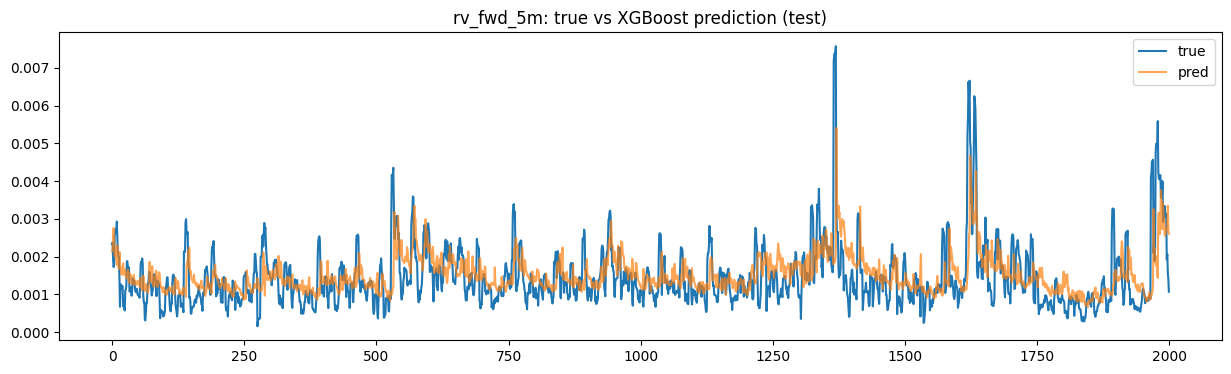

In [33]:
import matplotlib.pyplot as plt

n_plot = 2000  # first 2000 dots，see the structure
plt.figure(figsize=(15, 4))
plt.plot(y_test.values[:n_plot], label="true")
plt.plot(y_pred_test[:n_plot], label="pred", alpha=0.7)
plt.legend()
plt.title("rv_fwd_5m: true vs XGBoost prediction (test)")
plt.show()


In [34]:
full_df_all = add_lags_by_symbol(small_df, TARGET, lags=[1, 5], lag_cols=lag_cols)
print("full_df_all.shape =", full_df_all.shape)

full_df_all.shape = (2105260, 84)


In [35]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt

TARGET = "rv_fwd_5m"   # define the target 

# make sure symbol exist
print(full_df_all["symbol"].value_counts())


symbol
BTCUSDT    1052630
ETHUSDT    1052630
Name: count, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
def time_split_with_time_column(df, train_ratio=0.7, val_ratio=0.15):
    """针对带 dt/ts_end 的 df 再写一遍，保证按时间切。"""
    df = df.sort_values("dt" if "dt" in df.columns else "ts_end")
    N = len(df)
    train_end = int(N * train_ratio)
    val_end = int(N * (train_ratio + val_ratio))
    train = df.iloc[:train_end]
    val   = df.iloc[train_end:val_end]
    test  = df.iloc[val_end:]
    return train, val, test


In [37]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def _gain_importance_df(model, feature_cols):
    booster = model.get_booster()
    score_raw = booster.get_score(importance_type="gain")  # dict: feature_name -> gain

    # 兼容 f0/f1/... 映射（你原 notebook 里也这么做） :contentReference[oaicite:2]{index=2}
    if len(score_raw) == 0:
        return pd.DataFrame({"feature": [], "gain": []})

    if all(k.startswith("f") and k[1:].isdigit() for k in score_raw.keys()):
        idx_to_name = {f"f{i}": col for i, col in enumerate(feature_cols)}
        score = {idx_to_name[k]: v for k, v in score_raw.items() if k in idx_to_name}
    else:
        score = score_raw

    imp_df = (
        pd.DataFrame({"feature": list(score.keys()), "gain": list(score.values())})
        .sort_values("gain", ascending=False)
        .reset_index(drop=True)
    )
    imp_df["gain_norm"] = imp_df["gain"] / (imp_df["gain"].sum() + 1e-12)
    return imp_df

def train_xgb_and_get_gain(df_in, target, params=None):
    df_in = df_in.dropna(subset=[target]).copy()
    if len(df_in) < 5000:
        return None, None, None

    # 你已有的时间切分函数
    train_df, val_df, test_df = time_split_with_time_column(df_in)

    # === 关键：drop 掉非特征列（时间/标识/字符串regime等）===
    drop_cols = [c for c in ["dt", "ts_end", "symbol", "regime"] if c in train_df.columns]
    train_df = train_df.drop(columns=drop_cols, errors="ignore")
    val_df   = val_df.drop(columns=drop_cols, errors="ignore")
    test_df  = test_df.drop(columns=drop_cols, errors="ignore")

    feature_cols = train_df.columns.difference([target])

    # 再保险：只保留数值列（避免还有别的 object 列混进来）
    X_train = train_df[feature_cols].select_dtypes(include=[np.number])
    X_val   = val_df[feature_cols].select_dtypes(include=[np.number])
    X_test  = test_df[feature_cols].select_dtypes(include=[np.number])

    # 同步 y
    y_train = train_df.loc[X_train.index, target]
    y_val   = val_df.loc[X_val.index, target]
    y_test  = test_df.loc[X_test.index, target]

    # 若有列被剔除（非数值），统一对齐列集合
    common_cols = X_train.columns.intersection(X_val.columns).intersection(X_test.columns)
    X_train, X_val, X_test = X_train[common_cols], X_val[common_cols], X_test[common_cols]

    if params is None:
        params = dict(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            tree_method="hist",
            eval_metric="rmse",
            random_state=42,
            n_jobs=-1
        )

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_pred = model.predict(X_test)
    metrics = {
        "rmse": float(np.sqrt(mean_squared_error(y_test, y_pred))),
        "mae": float(mean_absolute_error(y_test, y_pred)),
        "r2": float(r2_score(y_test, y_pred)),
        "corr": float(np.corrcoef(y_pred, y_test)[0, 1]) if len(y_test) > 1 else np.nan,
        "n_train": int(len(train_df)),
        "n_test": int(len(test_df)),
        "n_features": int(len(common_cols)),
    }

    # gain importance（沿用你之前的 booster.get_score）
    booster = model.get_booster()
    score_raw = booster.get_score(importance_type="gain")
    if len(score_raw) == 0:
        imp_df = pd.DataFrame({"feature": [], "gain": [], "gain_norm": []})
    else:
        # 兼容 f0, f1... 的情况
        if all(k.startswith("f") and k[1:].isdigit() for k in score_raw.keys()):
            idx_to_name = {f"f{i}": col for i, col in enumerate(common_cols)}
            score = {idx_to_name[k]: v for k, v in score_raw.items() if k in idx_to_name}
        else:
            score = score_raw

        imp_df = (pd.DataFrame({"feature": list(score.keys()), "gain": list(score.values())})
                  .sort_values("gain", ascending=False)
                  .reset_index(drop=True))
        imp_df["gain_norm"] = imp_df["gain"] / (imp_df["gain"].sum() + 1e-12)

    return model, imp_df, metrics

def add_regime_labels_by_train_quantile(df_sym_with_symbol, target, low_q=0.3, high_q=0.7):
    """
    关键点：分位数阈值只用 train 段来估计（避免“用未来定义 regime”的质疑）。
    """
    df = df_sym_with_symbol.copy()
    df = df.dropna(subset=[target])

    # 保留 symbol 外部切分需要；time_split 会按 dt 排序 :contentReference[oaicite:4]{index=4}
    train_df, _, _ = time_split_with_time_column(df)
    lo = train_df[target].quantile(low_q)
    hi = train_df[target].quantile(high_q)

    df["regime"] = np.where(df[target] <= lo, "low",
                    np.where(df[target] >= hi, "high", "mid"))
    return df, float(lo), float(hi)

# =========================
# 主循环：每个 symbol 跑 low/high 两套模型 + importance 对比
# =========================
symbols = full_df_all["symbol"].unique()
regime_results = []
regime_importance = {}  # (sym, regime) -> imp_df

for sym in symbols:
    print(f"\n========== {sym} ==========")
    df_sym = full_df_all[full_df_all["symbol"] == sym].copy()
    df_sym = df_sym.dropna(subset=[TARGET])

    # regime label
    df_sym, lo_thr, hi_thr = add_regime_labels_by_train_quantile(df_sym, TARGET, low_q=0.3, high_q=0.7)
    print(f"Regime thresholds (train-quantile): low<= {lo_thr:.6g}, high>= {hi_thr:.6g}")

    # 为了训练：drop symbol 列，但先按 regime 分组
    #（注意：保留 dt，让 time_split_with_time_column 能按时间切）
    for regime in ["low", "high"]:
        df_r = df_sym[df_sym["regime"] == regime].copy()
        if "symbol" in df_r.columns:
            df_r = df_r.drop(columns=["symbol"])

        model_r, imp_r, met_r = train_xgb_and_get_gain(df_r, TARGET)

        if model_r is None:
            print(f"⚠ {sym}-{regime}: too few rows, skip.")
            continue

        regime_results.append({
            "symbol": sym,
            "regime": regime,
            "rmse": met_r["rmse"],
            "mae": met_r["mae"],
            "r2": met_r["r2"],
            "corr": met_r["corr"],
            "n_train": met_r["n_train"],
            "n_test": met_r["n_test"],
            "n_features": met_r["n_features"],
            "thr_low": lo_thr,
            "thr_high": hi_thr,
        })
        regime_importance[(sym, regime)] = imp_r

        print(f"{sym}-{regime}: RMSE={met_r['rmse']:.6f}, n_features={met_r['n_features']}")

# 汇总 performance
regime_results_df = pd.DataFrame(regime_results)
print("\n=== Regime model performance summary ===")
display(regime_results_df.sort_values(["symbol", "regime"]))

# =========================
# 对比 importance：high - low 的 gain_norm 差值（越大越“高波动更依赖”）
# =========================
diff_tables = {}
topN = 25

for sym in symbols:
    key_low = (sym, "low")
    key_high = (sym, "high")
    if key_low not in regime_importance or key_high not in regime_importance:
        continue

    low_df = regime_importance[key_low][["feature", "gain_norm"]].rename(columns={"gain_norm": "gain_low"})
    high_df = regime_importance[key_high][["feature", "gain_norm"]].rename(columns={"gain_norm": "gain_high"})

    diff = low_df.merge(high_df, on="feature", how="outer").fillna(0.0)
    diff["delta_high_minus_low"] = diff["gain_high"] - diff["gain_low"]
    diff = diff.sort_values("delta_high_minus_low", ascending=False).reset_index(drop=True)

    diff_tables[sym] = diff

    print(f"\n--- {sym}: Top {topN} features more important in HIGH regime ---")
    display(diff.head(topN))

    print(f"\n--- {sym}: Top {topN} features more important in LOW regime ---")
    display(diff.tail(topN).sort_values("delta_high_minus_low"))

# 你 PPT 最常用：直接拿 diff_tables[sym].head(10) / tail(10) 做结论点



========== BTCUSDT ==========
Regime thresholds (train-quantile): low<= 0.000578683, high>= 0.00121632
BTCUSDT-low: RMSE=0.000108, n_features=81
BTCUSDT-high: RMSE=0.002122, n_features=81

========== ETHUSDT ==========
Regime thresholds (train-quantile): low<= 0.00066568, high>= 0.00136166
ETHUSDT-low: RMSE=0.000118, n_features=81
ETHUSDT-high: RMSE=0.001139, n_features=81

=== Regime model performance summary ===


,symbol,regime,rmse,mae,r2,corr,n_train,n_test,n_features,thr_low,thr_high
1,BTCUSDT,high,0.002122,0.000816,-3.302754,0.203599,239770,51380,81,0.000579,0.001216
0,BTCUSDT,low,0.000108,0.000089,0.111308,0.340579,197874,42402,81,0.000579,0.001216
3,ETHUSDT,high,0.001139,0.000742,0.222909,0.564770,252977,54210,81,0.000666,0.001362
2,ETHUSDT,low,0.000118,0.000097,0.121154,0.354258,187478,40174,81,0.000666,0.001362



--- BTCUSDT: Top 25 features more important in HIGH regime ---


,feature,gain_low,gain_high,delta_high_minus_low
0,BTC_lag15_ret_1m_lag1,0.000000,0.051114,0.051114
1,VWAP_deviation_lag5,0.003554,0.054574,0.051020
2,BTC_lag15_rv_30m,0.007309,0.054492,0.047183
3,l2__ask_30bps_fill_size_lag5,0.004498,0.048811,0.044313
4,BTC_lag15_OFI_raw,0.000000,0.039038,0.039038
5,BTC_corr_60m_lag5,0.000000,0.037143,0.037143
6,OFI_roc_10m_lag1,0.000000,0.033243,0.033243
7,L1_Imbalance_lag5,0.000000,0.032995,0.032995
8,ret_1m_lag1,0.000000,0.032774,0.032774
9,BTC_lag15_ret_1m,0.000000,0.030125,0.030125



--- BTCUSDT: Top 25 features more important in LOW regime ---


,feature,gain_low,gain_high,delta_high_minus_low
80,rv_30m_lag5,0.295075,0.020616,-0.274459
79,rv_30m,0.218595,0.001422,-0.217174
78,rv_30m_lag1,0.165916,0.005790,-0.160126
77,l1__tick_volatility,0.022598,0.004245,-0.018354
76,tr__trade_volatility,0.015408,0.002674,-0.012733
75,VWAP_deviation,0.013892,0.001320,-0.012572
74,BTC_lag15_rv_30m_lag5,0.018753,0.008938,-0.009815
73,Spread_ma_15m_lag1,0.014147,0.004568,-0.009579
72,BTC_lag15_rv_30m_lag1,0.009144,0.001031,-0.008113
71,tr__trade_volatility_lag1,0.011031,0.003438,-0.007593



--- ETHUSDT: Top 25 features more important in HIGH regime ---


,feature,gain_low,gain_high,delta_high_minus_low
0,l1__tick_count,0.023987,0.158000,0.134013
1,l1__tick_count_lag1,0.018560,0.060965,0.042405
2,l1__tick_volatility,0.006706,0.035046,0.028340
3,Mean_Spread,0.008581,0.027642,0.019061
4,Liquidity_Weighted_OFI,0.000000,0.017903,0.017903
5,OFI_roc_10m,0.000000,0.013794,0.013794
6,funding_rate,0.000000,0.013304,0.013304
7,Liquidity_Weighted_OFI_lag1,0.000000,0.012683,0.012683
8,Spread_ma_15m_lag5,0.004947,0.017567,0.012620
9,Liquidity_Weighted_OFI_lag5,0.000000,0.012275,0.012275



--- ETHUSDT: Top 25 features more important in LOW regime ---


,feature,gain_low,gain_high,delta_high_minus_low
80,rv_30m,0.232958,0.031224,-0.201735
79,rv_30m_lag5,0.185449,0.009497,-0.175952
78,rv_30m_lag1,0.181616,0.014726,-0.166891
77,Spread_ma_15m,0.039292,0.011150,-0.028142
76,Spread_ma_15m_lag1,0.018341,0.007811,-0.010531
75,tr__trade_volatility_lag1,0.011941,0.007375,-0.004566
74,VWAP_deviation_lag1,0.010346,0.005800,-0.004546
73,VWAP_deviation,0.011575,0.007203,-0.004372
72,tr__volume,0.009412,0.005049,-0.004363
71,Trade_Intensity_lag5,0.009831,0.006487,-0.003345


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_regime_feature_stability(regime_importance, sym, topN=10, use="high"):
    """
    regime_importance: dict {(symbol, regime)-> imp_df}, imp_df has ['feature','gain','gain_norm']
    sym: e.g., "BTCUSDT"
    topN: number of features shown in the plot
    use:
        - "high": use topN features ranked by High regime
        - "diff": use topN features ranked by |high-low|
        - "union": union of topN from high and low (then truncate to topN by max(high,low))
    """

    key_low  = (sym, "low")
    key_high = (sym, "high")
    if key_low not in regime_importance or key_high not in regime_importance:
        raise KeyError(f"Missing regime_importance for {sym}. Have: {list(regime_importance.keys())[:5]}...")

    low_df  = regime_importance[key_low][["feature", "gain_norm"]].rename(columns={"gain_norm": "low"})
    high_df = regime_importance[key_high][["feature", "gain_norm"]].rename(columns={"gain_norm": "high"})

    comp = low_df.merge(high_df, on="feature", how="outer").fillna(0.0)
    comp["diff"] = comp["high"] - comp["low"]
    comp["absdiff"] = comp["diff"].abs()
    comp["maxhl"] = comp[["high", "low"]].max(axis=1)

    # --- choose which features to display ---
    if use == "high":
        show = comp.sort_values("high", ascending=False).head(topN)
    elif use == "diff":
        show = comp.sort_values("absdiff", ascending=False).head(topN)
    elif use == "union":
        top_high = comp.sort_values("high", ascending=False).head(topN)["feature"]
        top_low  = comp.sort_values("low", ascending=False).head(topN)["feature"]
        union = pd.Index(top_high).union(pd.Index(top_low))
        show = comp[comp["feature"].isin(union)].copy()
        show = show.sort_values("maxhl", ascending=False).head(topN)
    else:
        raise ValueError("use must be one of {'high','diff','union'}")

    # --- normalize within displayed set (so x-axis is 'relative importance (normalized)' like your example) ---
    # You can normalize by sum or by max. Your example looks like max-normalized.
    # We'll do MAX-normalized so the largest bar becomes 1.0.
    denom = show["maxhl"].max() + 1e-12
    show["high_norm"] = show["high"] / denom
    show["low_norm"]  = show["low"]  / denom

    # sort so the biggest appears on top
    show = show.sort_values("maxhl", ascending=True)  # for barh, ascending=True puts biggest at top after invert? We'll control.
    feats = show["feature"].tolist()
    y = np.arange(len(feats))

    # --- plot ---
    plt.figure(figsize=(6.915, 4.598), dpi=100)
    
    bar_h = 0.38
    
    plt.barh(y + bar_h/2, show["high_norm"], height=bar_h, label="High Volatility")
    plt.barh(y - bar_h/2, show["low_norm"],  height=bar_h, label="Low Volatility")
    
    plt.yticks(y, feats)
    plt.xlabel("Relative Importance (Normalized)")
    plt.ylabel("Features")
    plt.title("Feature Stability (Regime Stability Check)")
    plt.legend(loc="lower right")
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()


    # --- print table like your screenshot ---
    top5_high = comp.sort_values("high", ascending=False).head(5)[["feature", "high", "low"]].copy()
    print("\n=== Top 5 Important Features in High Volatility (Crash) Regime ===")
    print(top5_high.set_index("feature").rename(columns={"high":"High Volatility", "low":"Low Volatility"}))


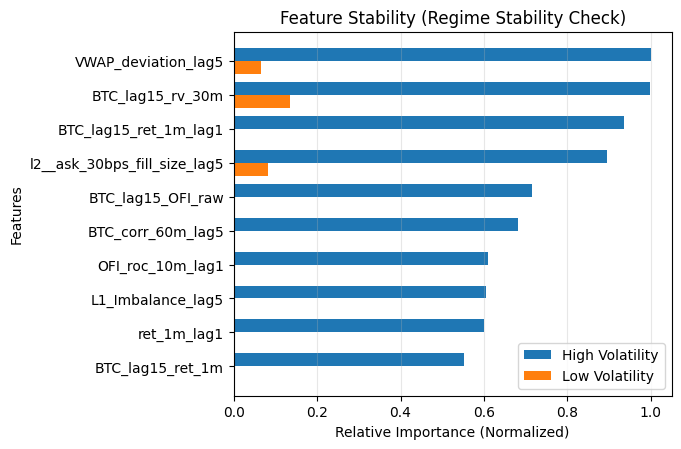


=== Top 5 Important Features in High Volatility (Crash) Regime ===
                              High Volatility  Low Volatility
feature                                                      
VWAP_deviation_lag5                  0.054574        0.003554
BTC_lag15_rv_30m                     0.054492        0.007309
BTC_lag15_ret_1m_lag1                0.051114        0.000000
l2__ask_30bps_fill_size_lag5         0.048811        0.004498
BTC_lag15_OFI_raw                    0.039038        0.000000


In [39]:
plot_regime_feature_stability(regime_importance, "BTCUSDT", topN=10, use="high")


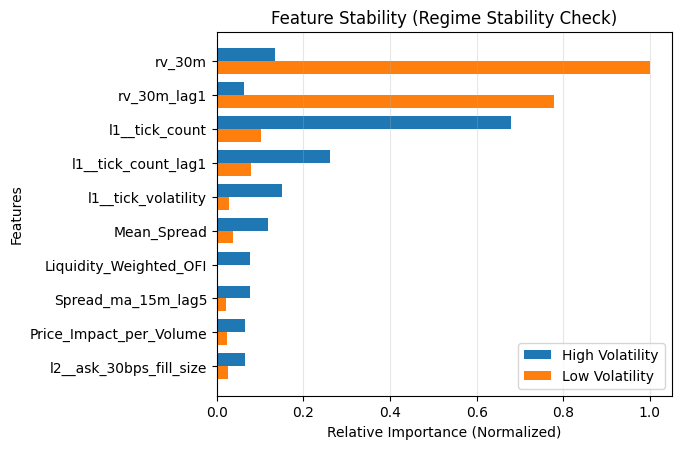


=== Top 5 Important Features in High Volatility (Crash) Regime ===
                     High Volatility  Low Volatility
feature                                             
l1__tick_count              0.158000        0.023987
l1__tick_count_lag1         0.060965        0.018560
l1__tick_volatility         0.035046        0.006706
rv_30m                      0.031224        0.232958
Mean_Spread                 0.027642        0.008581


In [40]:
plot_regime_feature_stability(regime_importance, "ETHUSDT", topN=10, use="high")


Total unique features: 81

Group counts:
group
OrderFlow         21
Volatility        15
Returns           15
Liquidity         15
TradeIntensity    15
Name: count, dtype: int64

✅ All features mapped into the 5 groups.


,feature,group
0,BTC_corr_60m,Volatility
1,BTC_corr_60m_lag1,Volatility
2,BTC_corr_60m_lag5,Volatility
3,BTC_lag15_OFI_raw,OrderFlow
4,BTC_lag15_OFI_raw_lag1,OrderFlow
5,BTC_lag15_OFI_raw_lag5,OrderFlow
6,BTC_lag15_ret_1m,Returns
7,BTC_lag15_ret_1m_lag1,Returns
8,BTC_lag15_ret_1m_lag5,Returns
9,BTC_lag15_rv_30m,Volatility


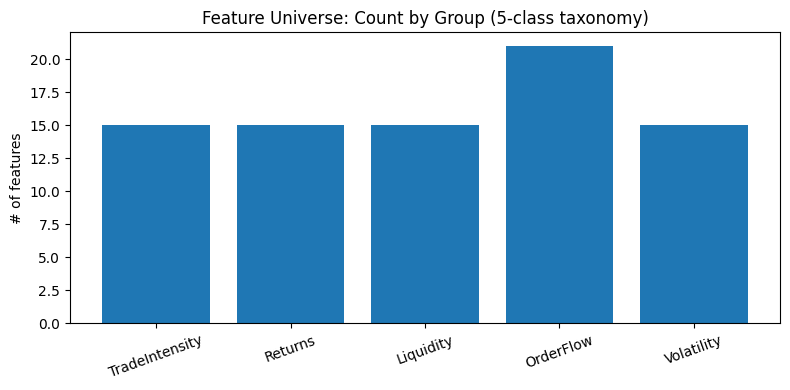

Saved: feature_taxonomy_5groups.csv


In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# ===== 0) Paste your feature universe here (space-separated) =====
FEATURE_UNIVERSE_TEXT = """
BTC_corr_60m BTC_corr_60m_lag1 BTC_corr_60m_lag5
BTC_lag15_OFI_raw BTC_lag15_OFI_raw_lag1 BTC_lag15_OFI_raw_lag5
BTC_lag15_ret_1m BTC_lag15_ret_1m_lag1 BTC_lag15_ret_1m_lag5
BTC_lag15_rv_30m BTC_lag15_rv_30m_lag1 BTC_lag15_rv_30m_lag5
L1_Imbalance L1_Imbalance_lag1 L1_Imbalance_lag5
Liquidity_Weighted_OFI Liquidity_Weighted_OFI_lag1 Liquidity_Weighted_OFI_lag5
Mean_Spread Mean_Spread_lag1 Mean_Spread_lag5
OFI_raw OFI_raw_lag1 OFI_raw_lag5
OFI_roc_10m OFI_roc_10m_lag1 OFI_roc_10m_lag5
OFI_std_30m OFI_std_30m_lag1 OFI_std_30m_lag5
Price_Impact_per_Volume Price_Impact_per_Volume_lag1 Price_Impact_per_Volume_lag5
Spread_ma_15m Spread_ma_15m_lag1 Spread_ma_15m_lag5
Trade_Intensity Trade_Intensity_lag1 Trade_Intensity_lag5
VPIN_proxy VPIN_proxy_lag1 VPIN_proxy_lag5
VWAP_deviation VWAP_deviation_lag1 VWAP_deviation_lag5
abs_ret_1m abs_ret_1m_lag1 abs_ret_1m_lag5
funding_rate funding_rate_lag1 funding_rate_lag5
l1__tick_count l1__tick_count_lag1 l1__tick_count_lag5
l1__tick_volatility l1__tick_volatility_lag1 l1__tick_volatility_lag5
l2__ask_30bps_fill_size l2__ask_30bps_fill_size_lag1 l2__ask_30bps_fill_size_lag5
l2__bid_30bps_fill_size l2__bid_30bps_fill_size_lag1 l2__bid_30bps_fill_size_lag5
log_volume log_volume_lag1 log_volume_lag5
ret_1m ret_1m_lag1 ret_1m_lag5
rv_30m rv_30m_lag1 rv_30m_lag5
signed_ret_1m signed_ret_1m_lag1 signed_ret_1m_lag5
tr__trade_volatility tr__trade_volatility_lag1 tr__trade_volatility_lag5
tr__volume tr__volume_lag1 tr__volume_lag5
""".strip()

FEATURES = FEATURE_UNIVERSE_TEXT.split()
FEATURES = sorted(set(FEATURES))  # unique + sorted

print("Total unique features:", len(FEATURES))


# ===== 1) Strict 5-group mapping rules (updated to cover your universe) =====
GROUP_ORDER = ["TradeIntensity", "Returns", "Liquidity", "OrderFlow", "Volatility"]

def map_feature_to_group(feat: str) -> str:
    f = str(feat)

    # --- BTC cross-asset: force-map to one of the 5 groups ---
    if f.startswith("BTC_"):
        if "ret" in f:
            return "Returns"
        if "OFI" in f or "Imbalance" in f or "VPIN" in f:
            return "OrderFlow"
        # corr / rv -> volatility state proxy
        return "Volatility"

    # --- Derivatives proxy (must go into one of 5 groups) ---
    if "funding_rate" in f:
        return "Volatility"

    # --- Liquidity / microstructure costs ---
    if ("Mean_Spread" in f) or ("Spread" in f) or ("spread" in f) or ("Spread_ma" in f):
        return "Liquidity"
    if ("fill_size" in f) or ("Price_Impact" in f) or ("depth" in f) or ("depth_ratio" in f):
        return "Liquidity"

    # --- Order flow ---
    if ("Liquidity_Weighted_OFI" in f) or ("OFI" in f) or ("OFL" in f) or ("Imbalance" in f) or ("VPIN" in f):
        return "OrderFlow"

    # --- Trade intensity ---
    if ("tick_count" in f) or ("Trade_Intensity" in f) or ("log_volume" in f) or ("tr__volume" in f) or ("volume" in f) or ("tick_volatility" in f):
        return "TradeIntensity"

    # --- Volatility state ---
    if ("rv" in f) or ("trade_volatility" in f) or ("tr__trade_volatility" in f) or ("volatility" in f):
        return "Volatility"

    # --- Returns / price moves ---
    if ("abs_ret" in f) or ("signed_ret" in f) or ("ret" in f) or ("VWAP_deviation" in f) or ("vwap_deviation" in f):
        return "Returns"

    return "Other"


# ===== 2) Build taxonomy table =====
taxonomy_df = pd.DataFrame({"feature": FEATURES})
taxonomy_df["group"] = taxonomy_df["feature"].apply(map_feature_to_group)

print("\nGroup counts:")
print(taxonomy_df["group"].value_counts())

# Hard check: you said you want all features classified into 5 groups
other_feats = taxonomy_df[taxonomy_df["group"] == "Other"]["feature"].tolist()
if len(other_feats) > 0:
    print("\n⚠ Still in Other (please paste back to fix rules):")
    for x in other_feats:
        print(x)
    raise ValueError("Some features are still mapped to 'Other'.")
else:
    print("\n✅ All features mapped into the 5 groups.")

display(taxonomy_df)


# ===== 3) (Optional) Quick visualize: counts by group =====
plt.figure(figsize=(8,4))
counts = taxonomy_df["group"].value_counts().reindex(GROUP_ORDER)
plt.bar(counts.index, counts.values)
plt.title("Feature Universe: Count by Group (5-class taxonomy)")
plt.ylabel("# of features")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


# ===== 4) (Optional) Save taxonomy for manual audit =====
taxonomy_df.to_csv("feature_taxonomy_5groups.csv", index=False)
print("Saved: feature_taxonomy_5groups.csv")

In [42]:
def group_importance_from_imp_df(
    imp_df: pd.DataFrame,
    normalize: bool = False,
    group_order=None
):
    """
    Aggregate feature importance into the strict 5-group taxonomy:
        TradeIntensity / Returns / Liquidity / OrderFlow / Volatility

    Parameters
    ----------
    imp_df : DataFrame
        Must contain columns:
            - "feature": feature name
            - "gain": feature importance (e.g., XGBoost gain)
    normalize : bool, default False
        If True, normalize aggregated gain to sum to 1.
    group_order : list[str], optional
        Desired order of groups in output.

    Returns
    -------
    pd.Series
        Index = group name
        Value = aggregated (or normalized) gain
    """

    group_gain = {}

    for _, row in imp_df.iterrows():
        feat = row["feature"]
        gain = row["gain"]

        group = map_feature_to_group(feat)

        if group not in group_gain:
            group_gain[group] = 0.0

        group_gain[group] += gain

    group_df = (
        pd.DataFrame(
            {"group": list(group_gain.keys()), "gain": list(group_gain.values())}
        )
    )

    # Optional ordering
    if group_order is not None:
        group_df["group"] = pd.Categorical(
            group_df["group"],
            categories=group_order,
            ordered=True
        )
        group_df = group_df.sort_values("group")

    # Optional normalization
    if normalize:
        total = group_df["gain"].sum()
        if total > 0:
            group_df["gain"] = group_df["gain"] / total

    return group_df.set_index("group")["gain"]


symbols in data: ['BTCUSDT' 'ETHUSDT']

Training FULL model for BTCUSDT
 shapes: (736841, 83) (157894, 83) (157895, 83)
BTCUSDT (FULL) - Test RMSE = 0.001261
BTCUSDT (FULL) - Test R²   = -0.9009
BTCUSDT (FULL) - Test Corr = 0.4231
BTCUSDT (FULL) - Test MAE  = 0.000487


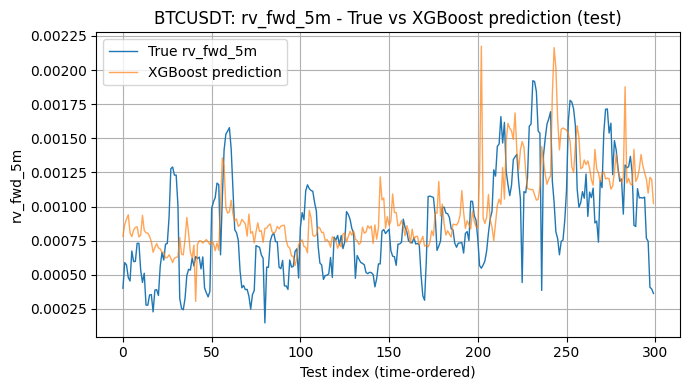


BTCUSDT - Group-level importance (Aggregated Gain):
group
OrderFlow         0.183798
Returns           0.145238
Liquidity         0.097595
Volatility        0.081655
TradeIntensity    0.055877
Name: gain, dtype: float64

Top 10 Important Features for BTCUSDT:
                        feature      gain
0             L1_Imbalance_lag5  0.037299
1           VWAP_deviation_lag5  0.026364
2              BTC_lag15_rv_30m  0.024113
3         BTC_lag15_ret_1m_lag1  0.023729
4                   rv_30m_lag5  0.021027
5             BTC_lag15_OFI_raw  0.019524
6        BTC_lag15_OFI_raw_lag5  0.017667
7              Mean_Spread_lag5  0.015681
8               log_volume_lag5  0.015084
9  l2__bid_30bps_fill_size_lag1  0.014977


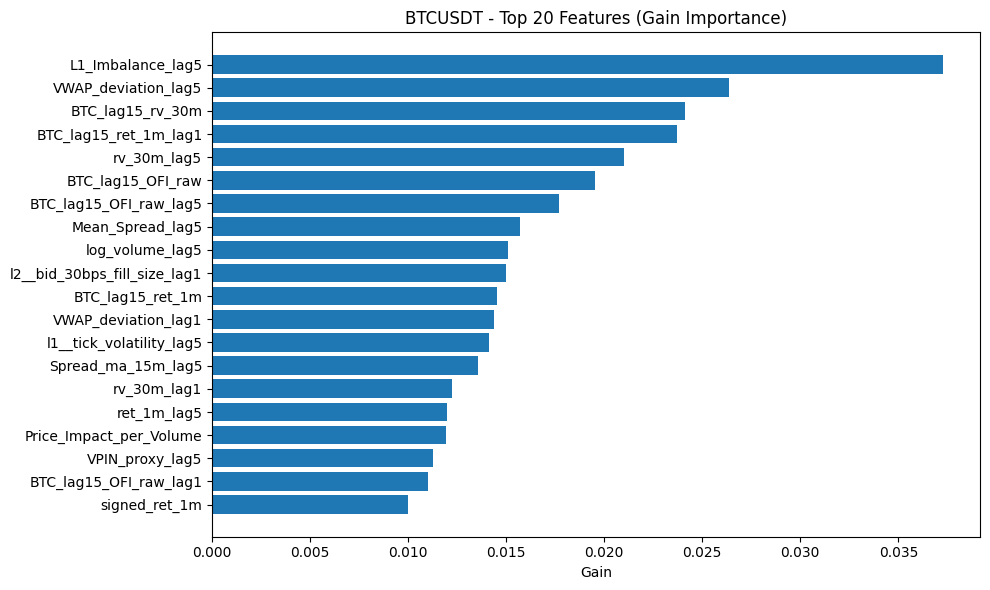


Training FULL model for ETHUSDT
 shapes: (736841, 83) (157894, 83) (157895, 83)
ETHUSDT (FULL) - Test RMSE = 0.000878
ETHUSDT (FULL) - Test R²   = 0.4208
ETHUSDT (FULL) - Test Corr = 0.6729
ETHUSDT (FULL) - Test MAE  = 0.000570


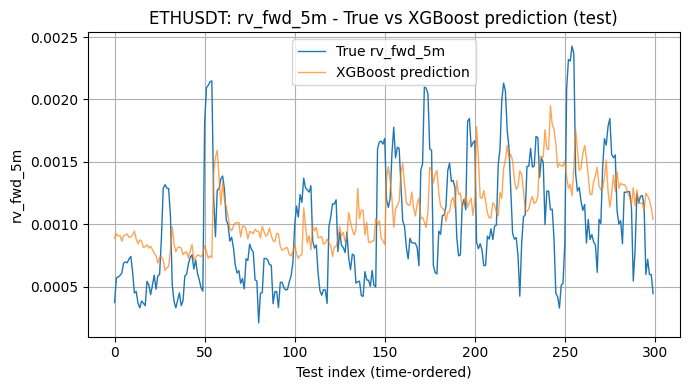


ETHUSDT - Group-level importance (Aggregated Gain):
group
TradeIntensity    0.006803
Volatility        0.004664
OrderFlow         0.002835
Liquidity         0.001978
Returns           0.001267
Name: gain, dtype: float64

Top 10 Important Features for ETHUSDT:
                  feature      gain
0          l1__tick_count  0.003599
1             rv_30m_lag1  0.001584
2                  rv_30m  0.001455
3     l1__tick_count_lag1  0.001093
4     l1__tick_volatility  0.000796
5           Spread_ma_15m  0.000314
6         Trade_Intensity  0.000308
7    tr__trade_volatility  0.000276
8  Liquidity_Weighted_OFI  0.000254
9             OFI_roc_10m  0.000232


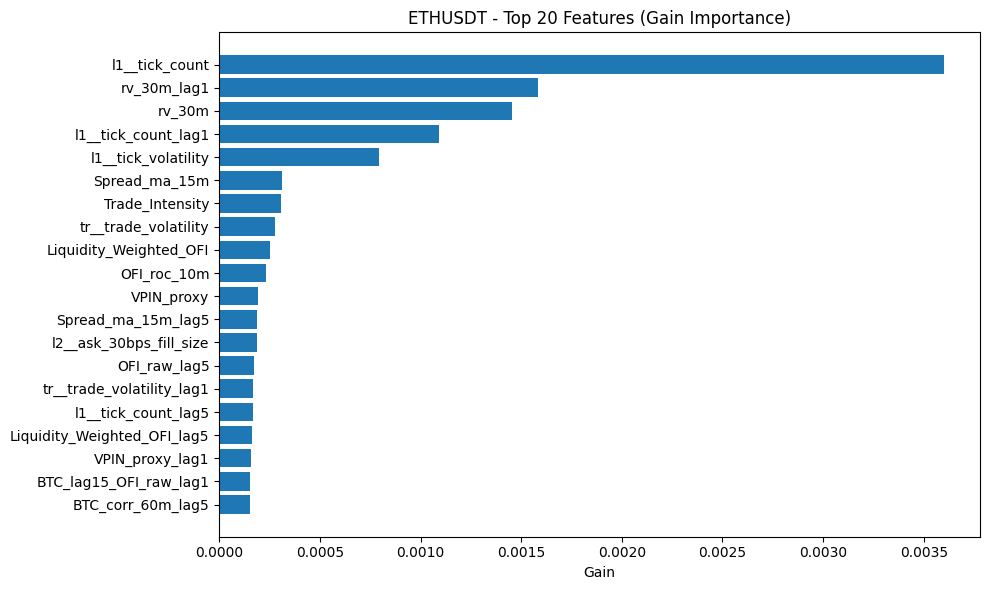


=== Baseline (FULL features) performance ===
    symbol  rmse_full  mae_full   r2_full  corr_full  n_train  n_test  \
0  BTCUSDT   0.001261  0.000487 -0.900898   0.423123   736841  157895   
1  ETHUSDT   0.000878  0.000570  0.420762   0.672934   736841  157895   

   n_features_full  
0               81  
1               81  

=== Group-level importance table (Aggregated Gain) ===
                 BTCUSDT   ETHUSDT
group                             
Liquidity       0.097595  0.001978
OrderFlow       0.183798  0.002835
Returns         0.145238  0.001267
TradeIntensity  0.055877  0.006803
Volatility      0.081655  0.004664

--- BTCUSDT group breakdown ---


,BTCUSDT
group,
OrderFlow,0.183798
Returns,0.145238
Liquidity,0.097595
Volatility,0.081655
TradeIntensity,0.055877



--- ETHUSDT group breakdown ---


,ETHUSDT
group,
TradeIntensity,0.006803
Volatility,0.004664
OrderFlow,0.002835
Liquidity,0.001978
Returns,0.001267


In [43]:
# ========= 1. 用全部特征训练每个 symbol 的 baseline XGBoost，并记录 Gain 重要性 =========

symbols = full_df_all["symbol"].unique()
print("symbols in data:", symbols)

results_full_gain = []           # baseline 性能
models_full_gain = {}            # baseline 模型
gain_importance_tables = {}      # sym -> DataFrame(feature, gain)

for sym in symbols:
    print("\n======================")
    print(f"Training FULL model for {sym}")
    print("======================")

    # 1) 取该 symbol 的数据，并去掉 label 为 NaN 的行
    df_sym = full_df_all[full_df_all["symbol"] == sym].copy()
    df_sym = df_sym.dropna(subset=[TARGET])
    if len(df_sym) < 1000:
        print(f"⚠ {sym}: data too small ({len(df_sym)} rows), skip.")
        continue

    # 2) 删掉 symbol 列，时间列先保留用于切分
    if "symbol" in df_sym.columns:
        df_sym = df_sym.drop(columns=["symbol"])

    # 3) 时间切分
    train_df, val_df, test_df = time_split_with_time_column(df_sym)
    print(" shapes:", train_df.shape, val_df.shape, test_df.shape)
    if len(train_df) == 0 or len(test_df) == 0:
        print(f"⚠ {sym}: train/test too small, skip.")
        continue

    # 4) 删掉时间列，不作为特征
    drop_cols = ["dt", "ts_end"]
    for c in drop_cols:
        if c in train_df.columns:
            train_df = train_df.drop(columns=c)
        if c in val_df.columns:
            val_df = val_df.drop(columns=c)
        if c in test_df.columns:
            test_df = test_df.drop(columns=c)

    assert TARGET in train_df.columns

    feature_cols = train_df.columns.difference([TARGET])

    X_train, y_train = train_df[feature_cols], train_df[TARGET]
    X_val,   y_val   = val_df[feature_cols],   val_df[TARGET]
    X_test,  y_test  = test_df[feature_cols],  test_df[TARGET]

    # 5) 训练 baseline XGBoost
    model_full = xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        tree_method="hist",
        eval_metric="rmse",
        # random_state=42,
    )

    model_full.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )

    # 6) 在 test 上评估
    y_pred_test = model_full.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test   = r2_score(y_test, y_pred_test)
    corr_test = np.corrcoef(y_pred_test, y_test)[0, 1]
    mae_test  = mean_absolute_error(y_test, y_pred_test)

    print(f"{sym} (FULL) - Test RMSE = {rmse_test:.6f}")
    print(f"{sym} (FULL) - Test R²   = {r2_test:.4f}")
    print(f"{sym} (FULL) - Test Corr = {corr_test:.4f}")
    print(f"{sym} (FULL) - Test MAE  = {mae_test:.6f}")

    # === True vs Pred 图 ===
    n_plot = 300  # 画前 2000 个点
    plt.figure(figsize=(7, 4))
    plt.plot(y_test.values[:n_plot], label="True rv_fwd_5m", linewidth=1.0)
    plt.plot(y_pred_test[:n_plot], label="XGBoost prediction", alpha=0.7, linewidth=1.0)
    plt.title(f"{sym}: rv_fwd_5m - True vs XGBoost prediction (test)")
    plt.xlabel("Test index (time-ordered)")
    plt.ylabel("rv_fwd_5m")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 7) Feature Importance (Gain) ===
    booster = model_full.get_booster()
    score_dict = booster.get_score(importance_type="gain")

    feature_names = list(X_train.columns)

    # 判断 key 是否是 f0,f1,f2 这种；否则视为已经是列名
    if all(k.startswith("f") and k[1:].isdigit() for k in score_dict.keys()):
        mapped_score = {
            feature_names[int(k[1:])]: v
            for k, v in score_dict.items()
        }
    else:
        mapped_score = score_dict

    imp_df = (
        pd.DataFrame({
            "feature": list(mapped_score.keys()),
            "gain": list(mapped_score.values())
        })
        .sort_values("gain", ascending=False)
        .reset_index(drop=True)
    )
    gain_importance_tables[sym] = imp_df

    # ===== 7b) Group-level Importance (p2-style, NEW taxonomy-based) =====

    # 1) 把 feature-level importance join 到 taxonomy
    imp_with_group = imp_df.merge(
        taxonomy_df[["feature", "group"]],
        on="feature",
        how="left"
    )
    
    # 2) 如果有 feature 没被 taxonomy 覆盖，直接打印出来（便于你立刻修 taxonomy）
    missing = imp_with_group[imp_with_group["group"].isna()]["feature"].unique()
    if len(missing) > 0:
        print(f"\n⚠ {sym}: Missing group mapping for {len(missing)} features:")
        for f in missing[:50]:
            print(" -", f)
        # 你也可以选择 raise，让它强制你修 taxonomy
        # raise ValueError("Some features missing in taxonomy mapping.")
    
    # 3) groupby sum gain（严格按 GROUP_ORDER 排序）
    group_imp = (
        imp_with_group
        .groupby("group")["gain"]
        .sum()
        .reindex(GROUP_ORDER)
        .fillna(0.0)
    )
    
    print(f"\n{sym} - Group-level importance (Aggregated Gain):")
    print(group_imp.sort_values(ascending=False))
    


    print(f"\nTop 10 Important Features for {sym}:")
    print(imp_df.head(10))

    plt.figure(figsize=(10, 6))
    plt.barh(imp_df["feature"].head(20)[::-1],
             imp_df["gain"].head(20)[::-1])
    plt.title(f"{sym} - Top 20 Features (Gain Importance)")
    plt.xlabel("Gain")
    plt.tight_layout()
    plt.show()

    # 8) 记录性能、模型
    results_full_gain.append({
        "symbol": sym,
        "rmse_full": rmse_test,
        "mae_full": mae_test,
        "r2_full": r2_test,
        "corr_full": corr_test,
        "n_train": len(train_df),
        "n_test": len(test_df),
        "n_features_full": len(feature_cols),
    })
    models_full_gain[sym] = model_full

# 汇总 baseline 结果
results_full_gain_df = pd.DataFrame(results_full_gain)
print("\n=== Baseline (FULL features) performance ===")
print(results_full_gain_df)

# ================================
# Group-level Importance (GAIN)
# ================================
group_table = {}
    
for sym, imp_df in gain_importance_tables.items():
    group_table[sym] = group_importance_from_imp_df(imp_df, normalize=False)
    
    group_table_df = pd.DataFrame(group_table).fillna(0.0)
    
print("\n=== Group-level importance table (Aggregated Gain) ===")
print(group_table_df)


# 如果你只想看 BTC / ETH
for sym in ["BTCUSDT", "ETHUSDT"]:
    if sym in group_table_df.columns:
        print(f"\n--- {sym} group breakdown ---")
        display(group_table_df[[sym]].sort_values(sym, ascending=False))



Re-training GAIN-FS model for BTCUSDT
 shapes: (736841, 83) (157894, 83) (157895, 83)
BTCUSDT (GAIN-FS) - Test RMSE = 0.001288
BTCUSDT (GAIN-FS) - Test R²   = -0.9836
BTCUSDT (GAIN-FS) - Test Corr = 0.3510
BTCUSDT (GAIN-FS) - Test MAE  = 0.000484


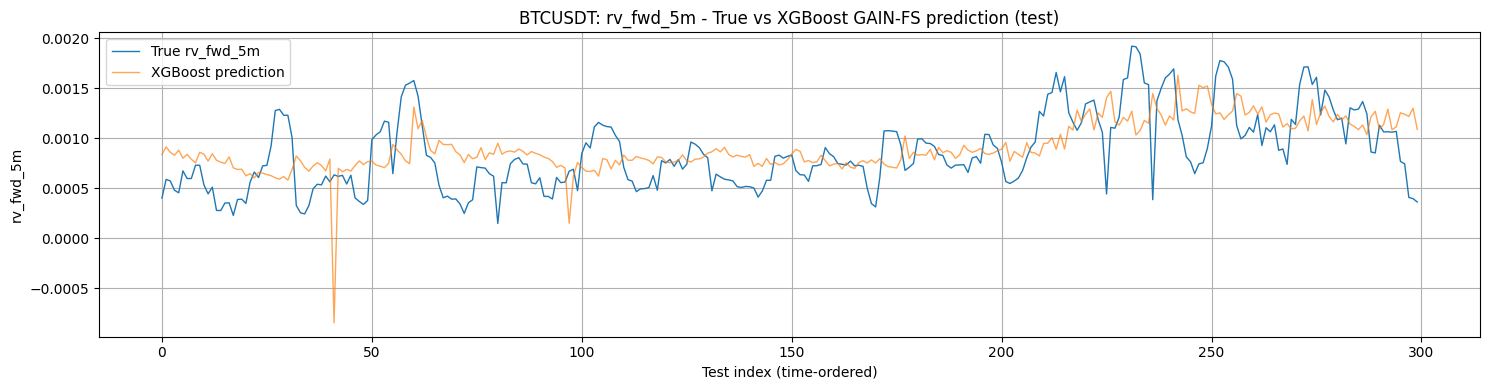


Re-training GAIN-FS model for ETHUSDT
 shapes: (736841, 83) (157894, 83) (157895, 83)
ETHUSDT (GAIN-FS) - Test RMSE = 0.000967
ETHUSDT (GAIN-FS) - Test R²   = 0.2976
ETHUSDT (GAIN-FS) - Test Corr = 0.6434
ETHUSDT (GAIN-FS) - Test MAE  = 0.000625


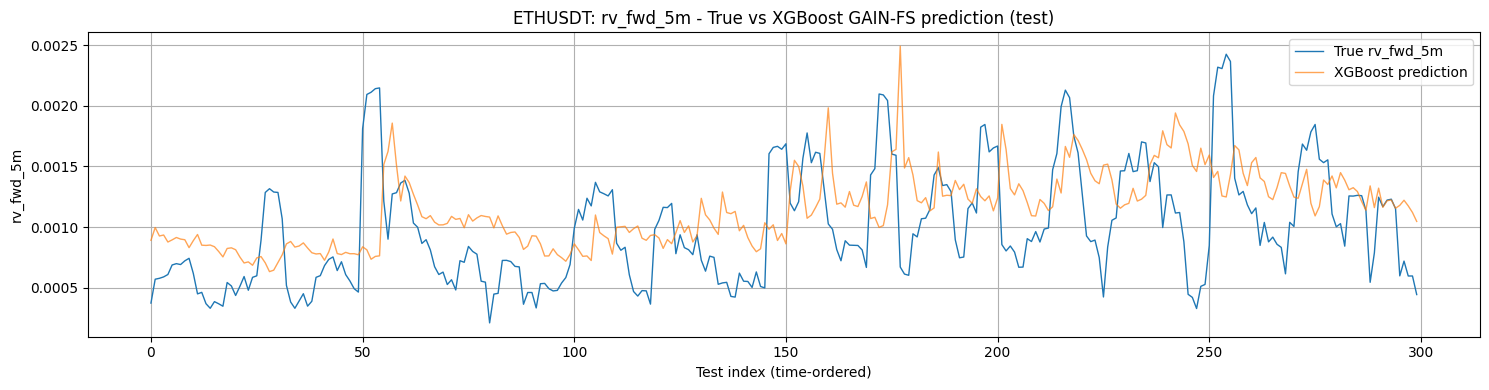


=== FULL vs GAIN-based Feature Selection (per symbol) ===
    symbol  rmse_full  mae_full   r2_full  corr_full  n_train  n_test  \
0  BTCUSDT   0.001261  0.000487 -0.900898   0.423123   736841  157895   
1  ETHUSDT   0.000878  0.000570  0.420762   0.672934   736841  157895   

   n_features_full  rmse_fs_gain  r2_fs_gain  mae_fs_gain  corr_fs_gain  \
0               81      0.001288   -0.983585     0.000484      0.350986   
1               81      0.000967    0.297643     0.000625      0.643425   

   n_features_fs_gain  
0                  20  
1                  20  


In [44]:
# ========= 2. 基于 Gain 重要性选 Top-K 特征，再训练精简模型 =========

top_k = 20   # 你可以改成 20/30/50，看性能 vs 复杂度的 trade-off

gain_feature_sets = {
    sym: imp_df.head(top_k)["feature"].tolist()
    for sym, imp_df in gain_importance_tables.items()
}

results_fs_gain = []      # feature selection 后的性能
models_fs_gain  = {}      # feature selection 后的模型

for sym in symbols:
    if sym not in gain_feature_sets:
        print(f"\n⚠ {sym}: no gain importance table, skip.")
        continue

    print("\n======================")
    print(f"Re-training GAIN-FS model for {sym}")
    print("======================")

    # 1) 取该 symbol 的数据
    df_sym = full_df_all[full_df_all["symbol"] == sym].copy()
    df_sym = df_sym.dropna(subset=[TARGET])
    if len(df_sym) < 1000:
        print(f"⚠ {sym}: data too small ({len(df_sym)} rows), skip.")
        continue

    if "symbol" in df_sym.columns:
        df_sym = df_sym.drop(columns=["symbol"])

    # 2) 时间切分
    train_df, val_df, test_df = time_split_with_time_column(df_sym)
    print(" shapes:", train_df.shape, val_df.shape, test_df.shape)
    if len(train_df) == 0 or len(test_df) == 0:
        print(f"⚠ {sym}: train/test too small, skip.")
        continue

    # 3) 删掉时间列
    drop_cols = ["dt", "ts_end"]
    for c in drop_cols:
        if c in train_df.columns:
            train_df = train_df.drop(columns=c)
        if c in val_df.columns:
            val_df = val_df.drop(columns=c)
        if c in test_df.columns:
            test_df = test_df.drop(columns=c)

    assert TARGET in train_df.columns

    # 4) 当前 symbol 真正可用的特征 = Gain Top-K ∩ 当前列
    selected_features = [
        f for f in gain_feature_sets[sym]
        if f in train_df.columns and f != TARGET
    ]
    if len(selected_features) == 0:
        print(f"⚠ {sym}: selected feature set is empty after intersection, skip.")
        continue

    X_train, y_train = train_df[selected_features], train_df[TARGET]
    X_val,   y_val   = val_df[selected_features],   val_df[TARGET]
    X_test,  y_test  = test_df[selected_features],  test_df[TARGET]

    # 5) 训练精简特征的 XGBoost
    model_fs = xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        tree_method="hist",
        eval_metric="rmse",
        # random_state=42,
    )

    model_fs.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )

    # 6) 在 test 上评估
    y_pred_test = model_fs.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test   = r2_score(y_test, y_pred_test)
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    corr_test = np.corrcoef(y_pred_test, y_test)[0, 1]

    print(f"{sym} (GAIN-FS) - Test RMSE = {rmse_test:.6f}")
    print(f"{sym} (GAIN-FS) - Test R²   = {r2_test:.4f}")
    print(f"{sym} (GAIN-FS) - Test Corr = {corr_test:.4f}")
    print(f"{sym} (GAIN-FS) - Test MAE  = {mae_test:.6f}")

    n_plot = 300  # 画前 2000 个点
    plt.figure(figsize=(15, 4))
    plt.plot(y_test.values[:n_plot], label="True rv_fwd_5m", linewidth=1.0)
    plt.plot(y_pred_test[:n_plot], label="XGBoost prediction", alpha=0.7, linewidth=1.0)
    plt.title(f"{sym}: rv_fwd_5m - True vs XGBoost GAIN-FS prediction (test)")
    plt.xlabel("Test index (time-ordered)")
    plt.ylabel("rv_fwd_5m")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    results_fs_gain.append({
        "symbol": sym,
        "rmse_fs_gain": rmse_test,
        "r2_fs_gain": r2_test,
        "mae_fs_gain": mae_test,
        "corr_fs_gain": corr_test,
        "n_train": len(train_df),
        "n_test": len(test_df),
        "n_features_fs_gain": len(selected_features),
    })
    models_fs_gain[sym] = model_fs

# 7) 汇总 “全特征” vs “Gain-FS” 对比
results_fs_gain_df = pd.DataFrame(results_fs_gain)

summary = results_full_gain_df.merge(
    results_fs_gain_df,
    on=["symbol", "n_train", "n_test"],
    how="left",
)

print("\n=== FULL vs GAIN-based Feature Selection (per symbol) ===")
print(summary)


In [45]:
# === Feature Importance: Gain ===
booster = model_full.get_booster()
score_dict = booster.get_score(importance_type='gain')

# 将 f0, f1, f2... 映射回真实列名（XGBoost 特征顺序与 DataFrame 顺序一致）
feature_names = list(X_train.columns)
mapped_score = { feature_names[int(k[1:])]: v for k, v in score_dict.items() }

# 转成 DataFrame
imp_df = (
    pd.DataFrame({
        "feature": list(mapped_score.keys()),
        "gain": list(mapped_score.values())
    })
    .sort_values("gain", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 10 Important Features for", sym)
print(imp_df.head(10))

# 保存到字典（如果你之后想 BFS、画图、比较两个币）
importance_dict[sym] = imp_df


ValueError: invalid literal for int() with base 10: 'TC_corr_60m'